### Load Data & Preprocessing

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection, metrics, neural_network, preprocessing
import warnings
warnings.filterwarnings('ignore')

path_airlines = "./datasets/airlines.csv"
path_airport = "./datasets/airports.csv"
path_flights = "./datasets/flights.csv"

df_airlines = pd.read_csv(path_airlines, low_memory=False)
df_airport = pd.read_csv(path_airport, low_memory=False)
df_flights = pd.read_csv(path_flights, low_memory=False)

Given the information before the flight, we want to predict (1) whether it is delayed at arrival (>15min) (2) how long it is delayed. 

### Classification
In this part, we use some flight information to predict the flight arrival delay, i.e.
'MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_TIME' to predict if
'ARRIVAL_DELAY' > 15

Here, we cannot include `delay details` column, otherwise the accuracy can easily reach 1.00 by the baseline logistic model. 

Let's start with not considering airport, in this way, the number of features will be fewer. 

In [2]:
delay_details = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'] # we never use it, since this information cannot be used in prediction in practice. 
columns_categorical = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE']
# , 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'
columns_numerical = ['SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ARRIVAL_DELAY']

In [213]:
# discard those row with >10% missing values
missing_columns = df_flights.loc[:, df_flights.isna().mean() >= 0.1].columns
df_flights = df_flights.drop(missing_columns, axis=1)
# discard nan rows
df_flights.dropna(inplace=True)

# discard cancelled or diverted flights.
df_flights = df_flights[df_flights['CANCELLED'] != 1]
df_flights = df_flights[df_flights['DIVERTED'] != 1]

# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()


# transform HHMM into minutes.
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(mintues)


# For those airline origin/dest airport not in IATA code, we replace them with 'OTHERS'
df_flights.loc[~df_flights['AIRLINE'].isin(df_airlines['IATA_CODE'].values),'AIRLINE']='OTHERS'
df_flights.loc[~df_flights['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'].values),'ORIGIN_AIRPORT']='OTHERS'
df_flights.loc[~df_flights['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE'].values),'DESTINATION_AIRPORT']='OTHERS'

['ATL',
 'ORD',
 'DFW',
 'DEN',
 'LAX',
 'SFO',
 'PHX',
 'IAH',
 'LAS',
 'MSP',
 'MCO',
 'SEA',
 'DTW',
 'BOS',
 'EWR',
 'CLT',
 'LGA',
 'SLC',
 'JFK',
 'BWI',
 'MDW',
 'DCA',
 'FLL',
 'SAN',
 'MIA',
 'PHL',
 'TPA',
 'DAL',
 'HOU',
 'BNA',
 'PDX',
 'STL',
 'HNL',
 'OAK',
 'AUS',
 'MSY',
 'MCI',
 'SJC',
 'SMF',
 'SNA',
 'CLE',
 'IAD',
 '10397',
 'RDU',
 'MKE',
 'SAT',
 '13930',
 'RSW',
 'IND',
 'SJU']

(98189, 38)

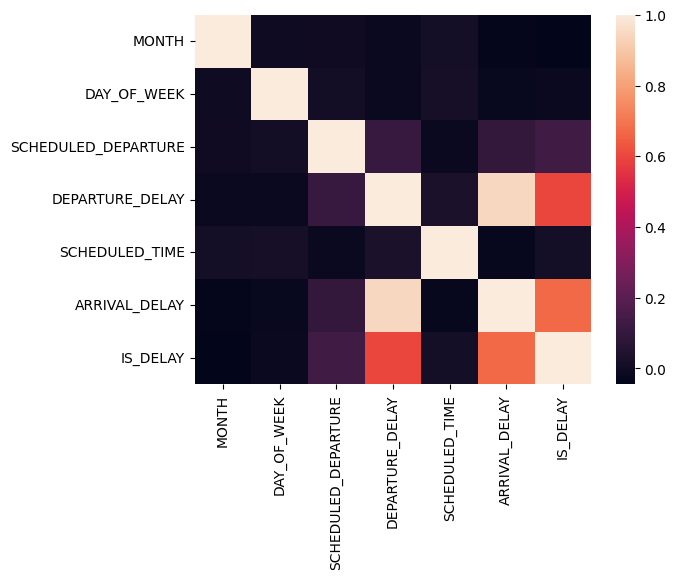

In [3]:
# only consider delayed variable
df_flights_cal = df_flights.sample(100000).reset_index(drop=True)


# Keeping those item (see eda.ipynb for reason)
df_flights_cal_keep = df_flights_cal[columns_categorical + columns_numerical].copy()

delay = []
for row in df_flights_cal_keep['ARRIVAL_DELAY']:
    if row > 15:
        delay.append(1)
    else:
        delay.append(0)  
df_flights_cal_keep['IS_DELAY'] = delay
sns.heatmap(df_flights_cal_keep.corr())

# convert categorical to onehot
df_flights_cal_dummies = pd.get_dummies(df_flights_cal_keep[columns_categorical].astype(str))
df_flights_cal_keep = df_flights_cal_keep.drop(columns_categorical, axis=1)
df_flights_cal_keep=pd.concat([df_flights_cal_keep,df_flights_cal_dummies],axis=1)
df_flights_cal_keep.shape

In [4]:
df_flights_cal_keep['IS_DELAY'].value_counts()

0    80303
1    17886
Name: IS_DELAY, dtype: int64

The dataset is unbalanced. We create and balance the training dataset in the following. We keep the test dataset untouched, since we wouldn't have access to the target variable to perform resampling. 
Also, we use the minmax scaler, one hot item will not be changed by this scaler.

In [5]:
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

X_imbalanced = df_flights_cal_keep.drop(['ARRIVAL_DELAY', 'IS_DELAY'],axis=1)
X_imbalanced_columns = X_imbalanced.columns
X_imbalanced = MinMaxScaler().fit_transform(X_imbalanced)
y_imbalanced = df_flights_cal_keep['IS_DELAY'].to_numpy()

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


def evaluate_classification(classification, ax=None):
    # ensure same distribution in train and test dataset
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    if ax is None:
        fig, ax = plt.subplots()
    name = str(classification)
    displays = []
    models = []
    for i, (train_ix, test_ix) in enumerate(kfold.split(X_imbalanced, y_imbalanced)):
        X_train_imbalanced, X_test = X_imbalanced[train_ix], X_imbalanced[test_ix]
        y_train_imbalanced, y_test = y_imbalanced[train_ix], y_imbalanced[test_ix]
        # upsample minority classes
        X_train_oversampled, y_train_oversampled = resample(X_train_imbalanced[y_train_imbalanced == 1], y_train_imbalanced[y_train_imbalanced == 1], replace=True, n_samples=X_train_imbalanced[y_train_imbalanced == 0].shape[0],random_state=0)
        X_train = np.vstack((X_train_imbalanced[y_train_imbalanced == 0].copy(), X_train_oversampled))
        y_train = np.hstack((y_train_imbalanced[y_train_imbalanced == 0].copy(), y_train_oversampled))
        # to dataframe
        X_train = pd.DataFrame(X_train, columns=X_imbalanced_columns)
        y_train = pd.DataFrame(y_train, columns=['IS_DELAY'])
        model = classification.fit(X_train, y_train)
        # print precision recall curve
        display = metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name+f" Fold {i+1}", ax=ax)
        displays.append(display)
        models.append(model)
        print("Classification Report" + f" Fold {i+1}\n")
        print(metrics.classification_report(y_test, classification.predict(X_test), target_names=["NOT DELAYED", "DELAYED"]))
    return models, displays

# X_train_imbalanced, X_test, y_train_imbalanced, y_test = model_selection.train_test_split(X_imbalanced, y_imbalanced, test_size=0.2, random_state=0)



Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.95      0.95     16061
     DELAYED       0.77      0.80      0.78      3577

    accuracy                           0.92     19638
   macro avg       0.86      0.87      0.87     19638
weighted avg       0.92      0.92      0.92     19638

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.95      0.95     16061
     DELAYED       0.78      0.79      0.79      3577

    accuracy                           0.92     19638
   macro avg       0.87      0.87      0.87     19638
weighted avg       0.92      0.92      0.92     19638

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.94      0.95     16061
     DELAYED       0.76      0.79      0.78      3577

    accuracy                           0.92     19638
   macro avg       0.86      0.87     

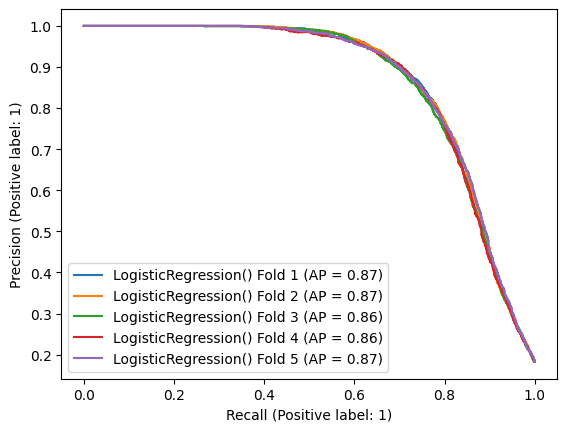

In [6]:
from sklearn.linear_model import LogisticRegression
models_logit, displays_logit = evaluate_classification(LogisticRegression())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.93      0.93     16061
     DELAYED       0.70      0.72      0.71      3577

    accuracy                           0.89     19638
   macro avg       0.82      0.83      0.82     19638
weighted avg       0.89      0.89      0.89     19638

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.93      0.93      0.93     16061
     DELAYED       0.69      0.70      0.70      3577

    accuracy                           0.89     19638
   macro avg       0.81      0.82      0.81     19638
weighted avg       0.89      0.89      0.89     19638

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.93      0.93     16061
     DELAYED       0.70      0.72      0.71      3577

    accuracy                           0.89     19638
   macro avg       0.82      0.82     

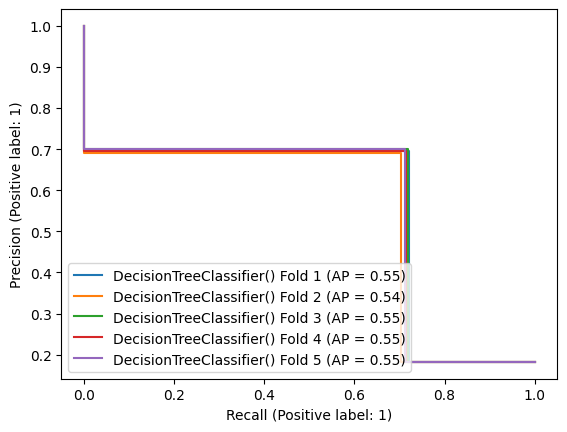

In [7]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
_, displays_dt = evaluate_classification(DecisionTreeClassifier())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.97      0.96     16061
     DELAYED       0.84      0.75      0.79      3577

    accuracy                           0.93     19638
   macro avg       0.89      0.86      0.87     19638
weighted avg       0.93      0.93      0.93     19638

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.94      0.97      0.96     16061
     DELAYED       0.86      0.74      0.80      3577

    accuracy                           0.93     19638
   macro avg       0.90      0.86      0.88     19638
weighted avg       0.93      0.93      0.93     19638

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.97      0.96     16061
     DELAYED       0.84      0.75      0.79      3577

    accuracy                           0.93     19638
   macro avg       0.89      0.86     

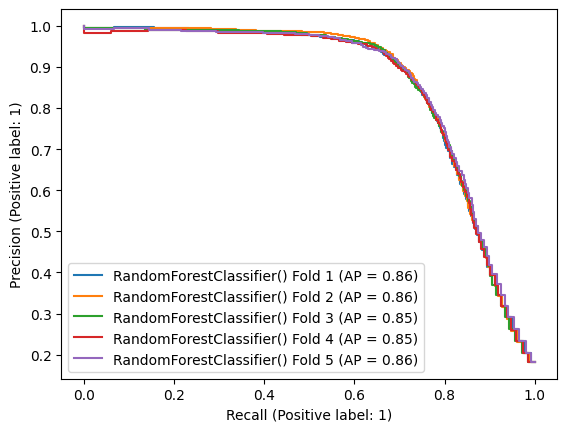

In [8]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
_, displays_rf = evaluate_classification(RandomForestClassifier())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.93      0.94     16061
     DELAYED       0.73      0.82      0.77      3577

    accuracy                           0.91     19638
   macro avg       0.84      0.87      0.86     19638
weighted avg       0.92      0.91      0.91     19638

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.94      0.95     16061
     DELAYED       0.75      0.81      0.78      3577

    accuracy                           0.92     19638
   macro avg       0.85      0.87      0.86     19638
weighted avg       0.92      0.92      0.92     19638

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.93      0.95     16061
     DELAYED       0.74      0.82      0.77      3577

    accuracy                           0.91     19638
   macro avg       0.85      0.88     

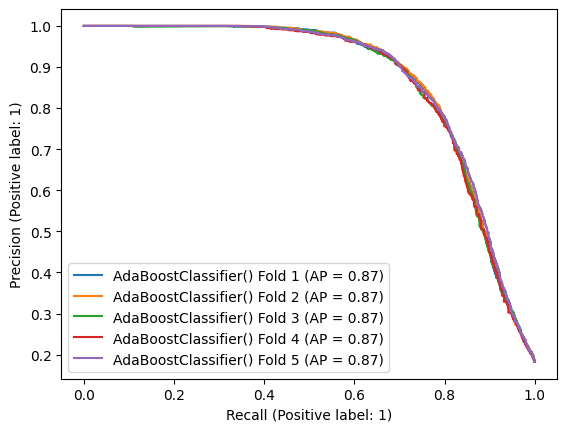

In [9]:
from sklearn.ensemble import AdaBoostClassifier
_, displays_ada = evaluate_classification(AdaBoostClassifier())

Classification Report Fold 1

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.92      0.94     16061
     DELAYED       0.71      0.83      0.76      3577

    accuracy                           0.91     19638
   macro avg       0.83      0.88      0.85     19638
weighted avg       0.91      0.91      0.91     19638

Classification Report Fold 2

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.93      0.94     16061
     DELAYED       0.72      0.83      0.77      3577

    accuracy                           0.91     19638
   macro avg       0.84      0.88      0.86     19638
weighted avg       0.92      0.91      0.91     19638

Classification Report Fold 3

              precision    recall  f1-score   support

 NOT DELAYED       0.96      0.92      0.94     16061
     DELAYED       0.70      0.82      0.76      3577

    accuracy                           0.90     19638
   macro avg       0.83      0.87     

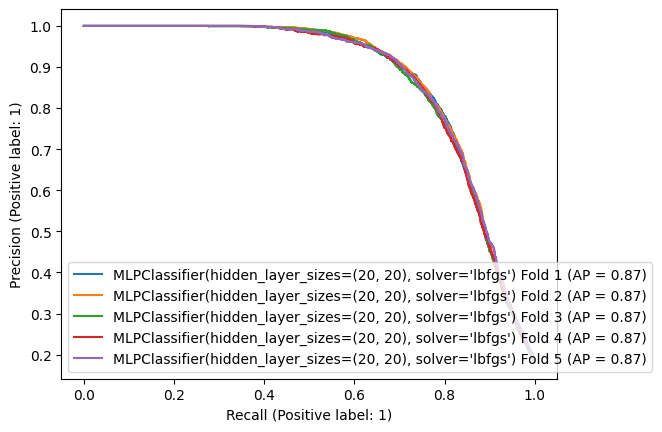

In [10]:
# MLP hidden size (50, 50)
from sklearn.neural_network import MLPClassifier
_, displays_mlp = evaluate_classification(MLPClassifier(hidden_layer_sizes=(20, 20) ,solver='lbfgs'))

We plot the Precision-Recall curve together. Since the dataset is imbalanced, we should not use ROC curve here.

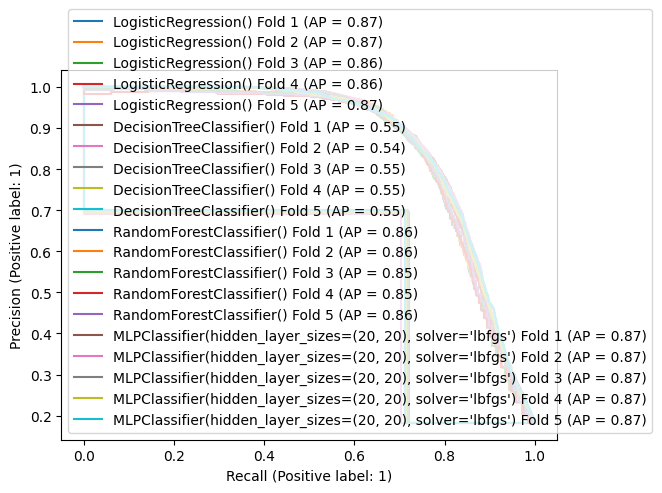

In [11]:
fig, ax = plt.subplots()
for display in displays_logit+displays_dt+displays_rf+displays_mlp:
    display.plot(ax=ax)

We find that logistic regression is the best algorithm in terms of accuracy and efficiency. Then, we analyze the effect of the variable using this model. Since the data is scaled, the size of coefficient can determine the effect of each variable.  

In [12]:
logit = models_logit[0]
logit_feature_dict = dict(zip(logit.feature_names_in_.tolist(), logit.coef_[0].tolist()))
airline_keys = [(x, np.exp(logit_feature_dict[x])) for x in logit_feature_dict.keys() if 'AIRLINE' in x]
airline_keys.sort(key=lambda x: x[1], reverse=True)

In [13]:
airline_keys[0:10]

[('AIRLINE_F9', 1.466823758370831),
 ('AIRLINE_NK', 1.458098288799862),
 ('AIRLINE_MQ', 1.1782973253742512),
 ('AIRLINE_US', 1.1179903708250387),
 ('AIRLINE_B6', 1.0752349872646751),
 ('AIRLINE_OO', 1.0611447020186513),
 ('AIRLINE_EV', 1.051359177486828),
 ('AIRLINE_AA', 0.9995748438272888),
 ('AIRLINE_AS', 0.9245606402482457),
 ('AIRLINE_UA', 0.863929410783563)]

We can see that flights airline NK and F9 will be most likely to be delayed, and airline NK, F9, MQ, EV, US, VX, B6 will have positive effect (>1) of delay, it coincides with the averaged delay time w.r.t. each line. 

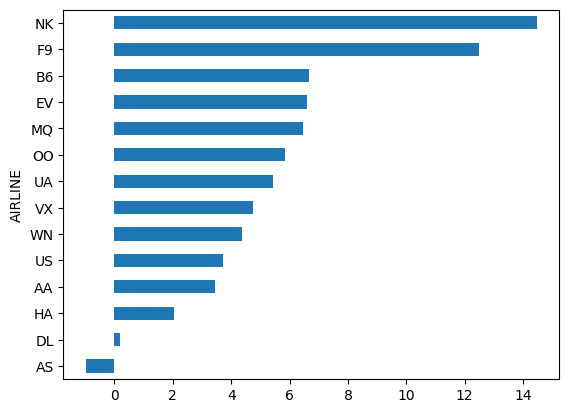

In [14]:
df_flights.groupby('AIRLINE').median()['ARRIVAL_DELAY'].sort_values().plot(kind='barh')
plt.show()

We look at the full coefficient, we find that 'DEPARTURE_DELAY' largely determines the arrival delay, which coincides with our ituition, we can also observe flights in MONTH 1, 2, 6, 7 are more likely to be delayed, and flights in week day 1, 3, 4 are likely to be delayed, but flight in week day 6 are not likely to be delayed. These observation coincides with the averaged delay time.

In [15]:
logit_feature_dict

{'SCHEDULED_DEPARTURE': 0.5933915550585885,
 'DEPARTURE_DELAY': 112.46396703429319,
 'SCHEDULED_TIME': 0.23471890165499637,
 'MONTH_1': 0.2935080909245922,
 'MONTH_10': -0.3607412474537418,
 'MONTH_11': -0.1492527423782449,
 'MONTH_12': 0.06873171312770711,
 'MONTH_2': 0.2041936983885502,
 'MONTH_3': 0.042811702045348614,
 'MONTH_4': 0.0531199648542839,
 'MONTH_5': -0.015499698149076495,
 'MONTH_6': 0.1567153700645517,
 'MONTH_7': 0.004202390015122976,
 'MONTH_8': -0.10887117271337378,
 'MONTH_9': -0.20366920476074926,
 'DAY_OF_WEEK_1': 0.04555187266600206,
 'DAY_OF_WEEK_2': 0.013104743739153343,
 'DAY_OF_WEEK_3': 0.01034441247251004,
 'DAY_OF_WEEK_4': 0.1284244739664019,
 'DAY_OF_WEEK_5': -0.0041190005698323665,
 'DAY_OF_WEEK_6': -0.16198044024960145,
 'DAY_OF_WEEK_7': -0.04607719805795192,
 'AIRLINE_AA': -0.00042524657722171536,
 'AIRLINE_AS': -0.07843663782552483,
 'AIRLINE_B6': 0.07253923049604903,
 'AIRLINE_DL': -0.4203791405559202,
 'AIRLINE_EV': 0.05008378183454364,
 'AIRLINE_F9

<Axes: ylabel='MONTH'>

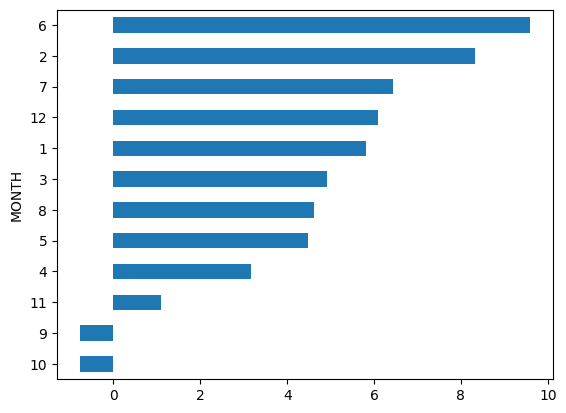

In [16]:
df_flights.groupby('MONTH').median()['ARRIVAL_DELAY'].sort_values().plot(kind='barh')

<Axes: ylabel='DAY_OF_WEEK'>

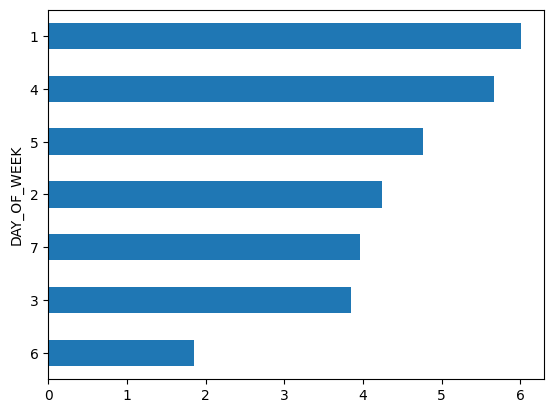

In [17]:
df_flights.groupby('DAY_OF_WEEK').median()['ARRIVAL_DELAY'].sort_values().plot(kind='barh')

If we add airport information, we consider the following, and observe no improvement. Hence, in this model, we will not introduce the airport information in the classification task. 

              precision    recall  f1-score   support

 NOT DELAYED       0.95      0.94      0.95     16035
     DELAYED       0.75      0.80      0.78      3596

    accuracy                           0.92     19631
   macro avg       0.85      0.87      0.86     19631
weighted avg       0.92      0.92      0.92     19631



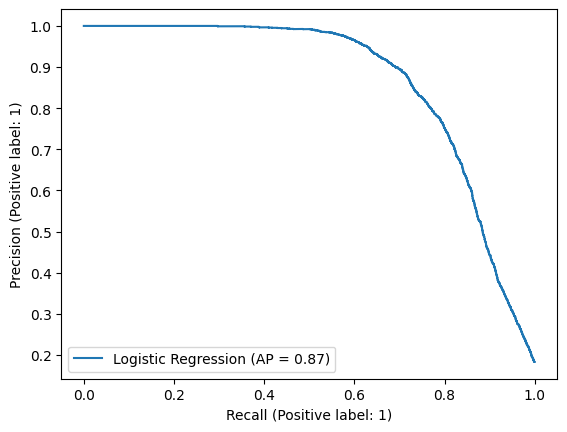

In [192]:
columns_categorical = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


# only consider delayed variable
df_flights_cal = df_flights.sample(100000).reset_index(drop=True)

df_flights_cal[delay_details] = df_flights_cal[delay_details].fillna(0)
# empty those row with >10% missing values
missing_columns = df_flights_cal.loc[:, df_flights_cal.isna().mean() >= 0.1].columns
df_flights_cal = df_flights_cal.drop(missing_columns, axis=1)
df_flights_cal.dropna(inplace=True)

# discard cancelled or diverted flights.
df_flights_cal = df_flights_cal[df_flights_cal['CANCELLED'] != 1]
df_flights_cal = df_flights_cal[df_flights_cal['DIVERTED'] != 1]

# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# transform HHMM into minutes.
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])
df_flights_cal['SCHEDULED_DEPARTURE'] = df_flights_cal['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights_cal['SCHEDULED_ARRIVAL'] = df_flights_cal['SCHEDULED_ARRIVAL'].apply(mintues)

# Keeping those item (see eda.ipynb for reason)
df_flights_cal_keep = df_flights_cal[columns_categorical + columns_numerical].copy()

delay = []
for row in df_flights_cal_keep['ARRIVAL_DELAY']:
    if row > 15:
        delay.append(1)
    else:
        delay.append(0)  
df_flights_cal_keep['IS_DELAY'] = delay

# convert categorical to onehot
df_flights_cal_dummies = pd.get_dummies(df_flights_cal_keep[columns_categorical].astype(str))
df_flights_cal_keep = df_flights_cal_keep.drop(columns_categorical, axis=1)
df_flights_cal_keep=pd.concat([df_flights_cal_keep,df_flights_cal_dummies],axis=1)

few_columns = df_flights_cal_keep.loc[:, df_flights_cal_keep.sum(axis=1) <= 0.01].columns


from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_imbalanced = df_flights_cal_keep.drop(['ARRIVAL_DELAY', 'IS_DELAY'],axis=1)
X_imbalanced_columns = X_imbalanced.columns
X_imbalanced = scaler.fit_transform(X_imbalanced)
y_imbalanced = df_flights_cal_keep['IS_DELAY']
X_train_imbalanced, X_test, y_train_imbalanced, y_test = model_selection.train_test_split(X_imbalanced, y_imbalanced, test_size=0.2, random_state=0)

X_train_oversampled, y_train_oversampled = resample(X_train_imbalanced[y_train_imbalanced == 1], y_train_imbalanced[y_train_imbalanced == 1], replace=True, 
                                                    n_samples=X_train_imbalanced[y_train_imbalanced == 0].shape[0],random_state=0)
X_train = np.vstack((X_train_imbalanced[y_train_imbalanced == 0].copy(), X_train_oversampled))
y_train = np.hstack((y_train_imbalanced[y_train_imbalanced == 0].copy(), y_train_oversampled))
X_train = pd.DataFrame(X_train, columns=X_imbalanced_columns)


from sklearn.linear_model import LogisticRegression
logit1 = LogisticRegression().fit(X_train, y_train)
y_pred = logit1.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=["NOT DELAYED", "DELAYED"]))
disp_logit = metrics.PrecisionRecallDisplay.from_estimator(logit1, X_test, y_test, name="Logistic Regression")

In [196]:
few_columns = df_flights_cal_keep.loc[:, df_flights_cal_keep.sum(axis=1) <= 0.01].columns


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [193]:
logit_feature_dict = dict(zip(logit1.feature_names_in_.tolist(), logit1.coef_[0].tolist()))
origin_keys = [(x, np.exp(logit_feature_dict[x])) for x in logit_feature_dict.keys() if 'ORIGIN' in x]
origin_keys.sort(key=lambda x: x[1], reverse=True)
origin_keys[:10]

[('ORIGIN_AIRPORT_EGE', 5.779119554189946),
 ('ORIGIN_AIRPORT_GCK', 3.767756893994995),
 ('ORIGIN_AIRPORT_JLN', 3.7668770762314647),
 ('ORIGIN_AIRPORT_GTR', 3.7587342930367265),
 ('ORIGIN_AIRPORT_LAN', 3.64701903705201),
 ('ORIGIN_AIRPORT_LCH', 3.551401558610297),
 ('ORIGIN_AIRPORT_LWS', 3.3540320491821762),
 ('ORIGIN_AIRPORT_BZN', 2.867923220968651),
 ('ORIGIN_AIRPORT_MGM', 2.841416267511472),
 ('ORIGIN_AIRPORT_COD', 2.580668605608006)]

### Regression
In this part, we use some delayed flight information to predict the exact value of flight delay, i.e.
'MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_TIME',
as well as flight `delay details`, i.e. 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
 to predict the value of flight delay. 

Let us first not consider the airport.

In [181]:
# only consider delayed variable
df_flights_reg = df_flights.sample(100000).reset_index(drop=True)

columns_categorical = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE']


df_flights_reg[delay_details] = df_flights_reg[delay_details].fillna(0)
# empty those column with >10% missing values
missing_columns = df_flights_reg.loc[:, df_flights_reg.isna().mean() >= 0.1].columns
df_flights_reg = df_flights_reg.drop(missing_columns, axis=1)
df_flights_reg.dropna(inplace=True)
# discard cancelled or diverted flights.
df_flights_reg = df_flights_reg[df_flights_reg['CANCELLED'] != 1]
df_flights_reg = df_flights_reg[df_flights_reg['DIVERTED'] != 1]

# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# For those airline origin/dest airport not in IATA code, we replace them with 'OTHERS'
df_flights_reg.loc[~df_flights_reg['AIRLINE'].isin(df_airlines['IATA_CODE'].values),'AIRLINE']='OTHERS'
df_flights_reg.loc[~df_flights_reg['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'].values),'ORIGIN_AIRPORT']='OTHERS'
df_flights_reg.loc[~df_flights_reg['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE'].values),'DESTINATION_AIRPORT']='OTHERS'

# transform HHMM into minutes.
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])
df_flights_reg['SCHEDULED_DEPARTURE'] = df_flights_reg['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights_reg['SCHEDULED_ARRIVAL'] = df_flights_reg['SCHEDULED_ARRIVAL'].apply(mintues)

# Keeping those item (see eda.ipynb for reason)
df_flights_reg_keep = df_flights_reg[columns_categorical + columns_numerical].copy()

# # convert categorical to onehot
df_flights_reg_dummies = pd.get_dummies(df_flights_reg_keep[columns_categorical].astype(str))
df_flights_reg_keep = df_flights_reg_keep.drop(columns_categorical, axis=1)
df_flights_reg_keep=pd.concat([df_flights_reg_keep,df_flights_reg_dummies],axis=1)
df_flights_reg_keep.shape

(98171, 37)

In [185]:
# Since the extreme values will largely impact the performance, we only keep those delayed less than 2 hours. 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

df_flights_reg_keep = df_flights_reg_keep[(df_flights_reg_keep['ARRIVAL_DELAY']<=120)].reset_index(drop=True).copy()


# we do not consider scaling nor upsampling here for regression. 
X_reg = df_flights_reg_keep.drop(['ARRIVAL_DELAY'],axis=1)
y_reg = df_flights_reg_keep['ARRIVAL_DELAY'].to_frame()



def evaluate_regression(regression):
    name = str(regression)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = cross_val_score(make_pipeline(MinMaxScaler(), regression), X_reg, y_reg, cv=cv)
    print(f"{name} Avergaed R^2 is {scores.mean()} with a standard deviation of {scores.std()}")


In [186]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
evaluate_regression(LinearRegression())
evaluate_regression(Ridge())
evaluate_regression(Lasso())
evaluate_regression(ElasticNet())

LinearRegression() Avergaed R^2 is 0.753727279066897 with a standard deviation of 0.004390690954323959
Ridge() Avergaed R^2 is 0.7537282853574673 with a standard deviation of 0.0043785425684494785
Lasso() Avergaed R^2 is 0.5363576772563211 with a standard deviation of 0.015338971972314791
ElasticNet() Avergaed R^2 is 0.019564518890742087 with a standard deviation of 0.0017052439638088862


In [187]:
from sklearn.tree import DecisionTreeRegressor
evaluate_regression(DecisionTreeRegressor(max_features='auto'))

DecisionTreeRegressor(max_features='auto') Avergaed R^2 is 0.49068647654419734 with a standard deviation of 0.005438391017014662


In [188]:
from sklearn.ensemble import RandomForestRegressor
evaluate_regression(RandomForestRegressor(n_estimators=50))

RandomForestRegressor(n_estimators=50) Avergaed R^2 is 0.7376566358328728 with a standard deviation of 0.00423158353072048


In [136]:
from sklearn.neural_network import MLPRegressor
evaluate_regression(MLPRegressor(hidden_layer_sizes=(10, 10), solver='lbfgs'))

MLPRegressor(hidden_layer_sizes=(50, 50), solver='lbfgs') Avergaed R^2 is 0.948938128439106 with a standard deviation of 0.0043965239267513044


Next, we include the airport. Since we are considering the arrival delay, we first consider the destination airport

In [166]:
# only consider delayed flights and features number are more, so we need to sample more
df_flights_reg = df_flights.sample(500000).reset_index(drop=True)
# we only consider the origin airport
columns_categorical = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE','ORIGIN_AIRPORT']


df_flights_reg[delay_details] = df_flights_reg[delay_details].fillna(0)
# empty those column with >10% missing values
missing_columns = df_flights_reg.loc[:, df_flights_reg.isna().mean() >= 0.1].columns
df_flights_reg = df_flights_reg.drop(missing_columns, axis=1)
df_flights_reg.dropna(inplace=True)
# discard cancelled or diverted flights.
df_flights_reg = df_flights_reg[df_flights_reg['CANCELLED'] != 1]
df_flights_reg = df_flights_reg[df_flights_reg['DIVERTED'] != 1]

# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# For those airline origin/dest airport not in IATA code, we replace them with 'OTHERS'
df_flights_reg.loc[~df_flights_reg['AIRLINE'].isin(df_airlines['IATA_CODE'].values),'AIRLINE']='OTHERS'
df_flights_reg.loc[~df_flights_reg['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'].values),'ORIGIN_AIRPORT']='OTHERS'
df_flights_reg.loc[~df_flights_reg['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE'].values),'DESTINATION_AIRPORT']='OTHERS'

# transform HHMM into minutes.
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])
df_flights_reg['SCHEDULED_DEPARTURE'] = df_flights_reg['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights_reg['SCHEDULED_ARRIVAL'] = df_flights_reg['SCHEDULED_ARRIVAL'].apply(mintues)

# Keeping those item (see eda.ipynb for reason)
df_flights_reg_keep = df_flights_reg[columns_categorical + columns_numerical].copy()

# # convert categorical to onehot
df_flights_reg_dummies = pd.get_dummies(df_flights_reg_keep[columns_categorical].astype(str))
df_flights_reg_keep = df_flights_reg_keep.drop(columns_categorical, axis=1)
df_flights_reg_keep=pd.concat([df_flights_reg_keep,df_flights_reg_dummies],axis=1)
df_flights_reg_keep.shape

# Since the extreme values will largely impact the performance, we only keep those delayed less than 2 hours. 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
# we only consider those flights which are delayed at departure
df_flights_reg_keep = df_flights_reg_keep[(df_flights_reg_keep['DEPARTURE_DELAY']>=15)&(df_flights_reg_keep['DEPARTURE_DELAY']<=120)]


# we do not consider scaling nor upsampling here for regression. 
X_reg = df_flights_reg_keep.drop(['ARRIVAL_DELAY'],axis=1)
y_reg = df_flights_reg_keep['ARRIVAL_DELAY'].to_frame()

def evaluate_regression(regression):
    name = str(regression)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = cross_val_score(regression, X_reg, y_reg, cv=cv)
    print(f"{name} Avergaed R^2 is {scores.mean()} with a standard deviation of {scores.std()}")


In [167]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
evaluate_regression(LinearRegression())
evaluate_regression(Ridge())
evaluate_regression(Lasso())
evaluate_regression(ElasticNet())

LinearRegression() Avergaed R^2 is -1356178834.0591316 with a standard deviation of 2090466194.9613686
Ridge() Avergaed R^2 is 0.7692171798942986 with a standard deviation of 0.006303665495485432
Lasso() Avergaed R^2 is 0.7642316716603197 with a standard deviation of 0.006211070854960391
ElasticNet() Avergaed R^2 is 0.7642328802799065 with a standard deviation of 0.00621245800408932


In [ ]:
from sklearn.neural_network import MLPRegressor
evaluate_regression(MLPRegressor(hidden_layer_sizes=(50, 50), solver='lbfgs'))

We realize that Ridge regression and NN performs the best. The interpretation of Ridge regression is simple. Let us first construct a g

In [110]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_reg, y_reg, test_size=0.2, random_state=0)
ridge = Ridge().fit(X_train, y_train)

In [108]:
ridge_feature_dict = dict(zip(ridge.feature_names_in_.tolist(), ridge.coef_[0].tolist()))
airport_keys = [(x, ridge_feature_dict[x]) for x in ridge_feature_dict.keys() if 'AIRPORT' in x]
airport_keys.sort(key=lambda x: x[1], reverse=True)

In [111]:
airport_keys

[('ORIGIN_AIRPORT_GTF', 4.70780851488648),
 ('ORIGIN_AIRPORT_BIL', 4.617825217427208),
 ('ORIGIN_AIRPORT_CIU', 3.6411844223057837),
 ('ORIGIN_AIRPORT_BZN', 3.4824527606238007),
 ('DESTINATION_AIRPORT_LBE', 3.360587619689741),
 ('ORIGIN_AIRPORT_YAK', 3.231025859343872),
 ('DESTINATION_AIRPORT_CDV', 3.2310258593438705),
 ('DESTINATION_AIRPORT_JLN', 3.1563539132942244),
 ('ORIGIN_AIRPORT_AVL', 2.903859534086698),
 ('ORIGIN_AIRPORT_BPT', 2.856474915076973),
 ('DESTINATION_AIRPORT_SCE', 2.715045340864814),
 ('ORIGIN_AIRPORT_BTV', 2.6268038540325755),
 ('ORIGIN_AIRPORT_HYS', 2.610800794126644),
 ('DESTINATION_AIRPORT_ISP', 2.5828065998203784),
 ('DESTINATION_AIRPORT_GJT', 2.5558278500266383),
 ('DESTINATION_AIRPORT_DBQ', 2.5449240616076865),
 ('ORIGIN_AIRPORT_ORF', 2.537474758236871),
 ('DESTINATION_AIRPORT_MLB', 2.2795571032333943),
 ('ORIGIN_AIRPORT_VLD', 2.2217064728231977),
 ('ORIGIN_AIRPORT_DLG', 2.1965978901052523),
 ('ORIGIN_AIRPORT_LBB', 2.0728915575595863),
 ('ORIGIN_AIRPORT_CRP', 2

In [117]:
df_flights_reg_1 = df_flights_reg[(df_flights_reg['DEPARTURE_DELAY']>=15)&(df_flights_reg['DEPARTURE_DELAY']<=120)]

<Axes: ylabel='DESTINATION_AIRPORT'>

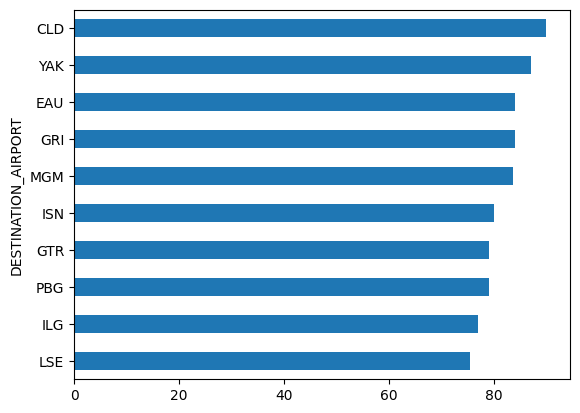

In [118]:
df_flights_reg_1.groupby('DESTINATION_AIRPORT').mean()['ARRIVAL_DELAY'].sort_values()[-10:].plot(kind='barh')

In [119]:
df_flights_reg_1.groupby('DESTINATION_AIRPORT').mean()['ARRIVAL_DELAY']['LBE']

27.5